#### load libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import warnings
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import shap

warnings.filterwarnings("ignore")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### loading data

In [2]:
athens_raw = pd.read_csv('listings.csv', delimiter=",", dtype="unicode")

In [3]:
# selecting only apartments
athens_aparts = athens_raw[athens_raw['room_type']=='Entire home/apt']

In [167]:
# selecting only 2-6 guests
athens_aparts['beds'] = pd.to_numeric(athens_aparts['beds'], errors="coerce")
athens_limited = athens_aparts[(athens_aparts['beds']>1) & (athens_aparts['beds']<7)]

#### removing unimportant columns
no predictive power expected from these features

In [168]:
# too many nan values
nans = ['host_response_rate',
         'host_acceptance_rate',
         'neighbourhood_group_cleansed',
         'bathrooms',
         'calendar_updated',
         'host_neighbourhood',
         'neighbourhood',
         'review_scores_value',
         'review_scores_checkin',
         'review_scores_communication',
         'review_scores_location',
         'review_scores_accuracy',
         'review_scores_cleanliness',
         'first_review',
         'last_review',
         'reviews_per_month',
         'review_scores_rating',
        'bedrooms'
       ]
athens_nonans = athens_limited.drop(nans, axis=1)

In [169]:
# no prediction
drops = [
    "host_thumbnail_url",
    "host_picture_url",
    "listing_url",
    "picture_url",
    "host_url",
    "last_scraped",
    "description",
    "neighborhood_overview",
    "host_about",
    "host_response_time",
    "name",
    "host_location",
    'source',
    'host_id',
    'host_name',
    'host_verifications', 
    'neighbourhood_cleansed', 
    'latitude',
    'longitude',
    'bathrooms_text',
    'license',
    'calendar_last_scraped',
    'has_availability',
    'property_type',
    'room_type' 
]
athens_dropped = athens_nonans.drop(drops, axis=1)

#### prepocess columns

In [170]:
athens_prep = athens_dropped.copy()

In [171]:
# drop broken lines - where id is not a character of numbers
athens_prep.id = pd.to_numeric(athens_prep.id, errors="coerce")

In [174]:
# to numeric
numeric_cols = ['host_listings_count',
                'host_listings_count',
                'accommodates',
                'minimum_nights', 
                'maximum_nights',
                'minimum_nights_avg_ntm', 
                'maximum_nights_avg_ntm',
                'availability_30',
                'availability_60',
                'availability_90',
                'availability_365',
                'number_of_reviews',
                'number_of_reviews_ltm',
                'number_of_reviews_l30d',
                'calculated_host_listings_count', 
                'calculated_host_listings_count_entire_homes', 
                'calculated_host_listings_count_private_rooms',
                'calculated_host_listings_count_shared_rooms',
                'host_total_listings_count',
                 'host_has_profile_pic',
                 'host_identity_verified',
                 'minimum_minimum_nights',
                 'maximum_minimum_nights',
                 'minimum_maximum_nights',
                 'maximum_maximum_nights'
               ]

In [175]:
# formatting to numeric values
for perc in numeric_cols:
    athens_prep[perc] = pd.to_numeric(athens_prep[perc], errors="coerce")

In [176]:
# remove $ sign from price
athens_prep['price'] = athens_prep['price'].str.replace("\\$", "")
athens_prep['price'] = pd.to_numeric(athens_prep['price'], errors="coerce")

In [177]:
# format binary variables
for binary in [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable"
]:
    athens_prep[binary] = athens_prep[binary].map({"t": True, "f": False})

#### make amentities as categorical variables

In [178]:
# convert to a string to a list
athens_prep["amenities"] = athens_prep["amenities"].str.strip("[]").str.replace('"', "").str.split(",")


In [179]:
# get dummies from each ammenity in lists
dummies = pd.get_dummies(athens_prep.amenities.apply(pd.Series).stack()).sum(level=0)

In [180]:
# know 5% of all records
percent5 = athens_prep.shape[0] * 0.05

In [181]:
# drop ammenities that are not present in at least 5% of records
drop_ammenities = [i for i in dummies.columns.tolist() if dummies.sum()[i] < percent5]
dummies_significant = dummies.drop(drop_ammenities, axis=1)

In [182]:
athens_final = pd.concat([athens_prep, dummies_significant], axis=1).drop('amenities', axis=1)

#### save preprocessed result

In [188]:
athens_final.to_csv('athens_final.csv', index=False)

In [2]:
athens_final = pd.read_csv('athens_final.csv')

### TASK1. Developing predictive model

#### create a train and test datasets
lets say we are at the end of 2022 year and what to predict a price to Jan 2023<br>
lets say the price did not change significantly for the last 10 year, which is very rough assumption made only for the sake of data fullness

In [3]:
athens_dated = athens_final.dropna(subset='host_since')

In [4]:
athens_dated['date_format'] = pd.to_datetime(athens_dated['host_since'])

In [5]:
athens_dated['date_format'].apply(lambda x: x.strftime('%Y-%m')).min()

'2008-08'

In [6]:
athens_dated['date_format'].apply(lambda x: x.strftime('%Y-%m')).max()

'2023-09'

In [7]:
# for model to understand convert boolean to num
for col in ['host_is_superhost', 'instant_bookable', 'host_has_profile_pic', 'host_identity_verified']:
    athens_dated[col] = athens_dated[col].astype('float')

In [8]:
# train data = last 5 years before 2023
train_data = athens_dated[(athens_dated['date_format']>='2018-01-01') & (athens_dated['date_format']<'2023-01-01')]
train_data = train_data.dropna(subset='price').reset_index(drop=True)

In [9]:
# test data = Jan of 2023
test_data = athens_dated[(athens_dated['date_format']>='2023-01-01') & (athens_dated['date_format']<'2023-02-01')]
test_data = test_data.dropna(subset='price').reset_index(drop=True)

In [10]:
# make x and y
x_train = train_data.drop(['id', 'scrape_id', 'host_since', 'price', 'date_format'], axis=1)
y_train = train_data[['id', 'price']].copy()

x_test = test_data.drop(['id', 'scrape_id', 'host_since', 'price', 'date_format'], axis=1)
y_test = test_data[['id', 'price']].copy()

#### fillnans

In [11]:
# host_is_superhost is the only column with nans, fill it with the majority class
print(x_train['host_is_superhost'].value_counts())
x_train['host_is_superhost'] = x_train['host_is_superhost'].fillna(0)
x_test['host_is_superhost'] = x_test['host_is_superhost'].fillna(0)

0.0    1681
1.0    1216
Name: host_is_superhost, dtype: int64


In [12]:
# no nans left
x_test.isna().sum().sum(), x_train.isna().sum().sum()

(0, 0)

#### ols model

In [70]:
model = sm.OLS(y_train[['price']], x_train)
results = model.fit()

In [71]:
# f statistics is less than 5% showing a stat significance of prediction
# also the adj. r2 value is high representing a good results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.746
Model:                            OLS   Adj. R-squared (uncentered):              0.735
Method:                 Least Squares   F-statistic:                              67.12
Date:                Sun, 03 Dec 2023   Prob (F-statistic):                        0.00
Time:                        02:02:46   Log-Likelihood:                         -16743.
No. Observations:                3010   AIC:                                  3.374e+04
Df Residuals:                    2884   BIC:                                  3.449e+04
Df Model:                         126                                                  
Covariance Type:            nonrobust                                                  
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
host_is_superhost                               11.1946      2.887      3.877      0.000       5.534      16.856
host_listings_count                              0.0076      0.110      0.069      0.945      -0.209       0.224
host_total_listings_count                       -0.0055      0.054     -0.102      0.919      -0.111       0.100
host_has_profile_pic                             0.1418      7.184      0.020      0.984     -13.945      14.229
host_identity_verified                         -14.0147      5.767     -2.430      0.015     -25.323      -2.707
accommodates                                    14.8601      1.109     13.394      0.000      12.685      17.036
beds                                             0.3886      1.744      0.223      0.824      -3.031       3.808
minimum_nights                                  -0.0842      0.970     -0.087      0.931      -1.987       1.818
maximum_nights                                   0.0072      0.003      2.240      0.025       0.001       0.014
minimum_minimum_nights                           0.1822      0.906      0.201      0.841      -1.595       1.960
maximum_minimum_nights                          -0.0096      0.586     -0.016      0.987      -1.159       1.140
minimum_maximum_nights                          -0.0026      0.017     -0.152      0.879      -0.036       0.031
maximum_maximum_nights                           0.0373      0.016      2.395      0.017       0.007       0.068
minimum_nights_avg_ntm                          -0.1422      0.641     -0.222      0.825      -1.399       1.115
maximum_nights_avg_ntm                          -0.0366      0.026     -1.389      0.165      -0.088       0.015
availability_30                                 -0.2306      0.381     -0.606      0.545      -0.977       0.516
availability_60                                  0.2029      0.393      0.516      0.606      -0.568       0.974
availability_90                                  0.0144      0.203      0.071      0.943      -0.384       0.413
availability_365                                 0.0079      0.014      0.578      0.563      -0.019       0.035
number_of_reviews                               -0.0118      0.035     -0.334      0.738      -0.081       0.057
number_of_reviews_ltm                            0.0627      0.142      0.442      0.659      -0.216       0.341
number_of_reviews_l30d                          -1.5717      0.901     -1.745      0.081      -3.338       0.195
instant_bookable                                10.0662      2.834      3.552      0.000       4.510      15.622
calculated_host_listings_count                

In [72]:
# RMSE  for the holdout is 39.1
y_pred_ols = results.predict(x_test)
mse_ols = mean_squared_error(y_test['price'], y_pred_ols)
np.sqrt(mse_ols)

39.08806197746516

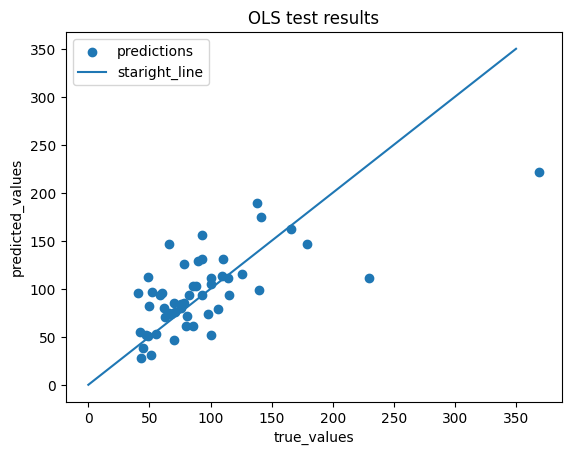

In [74]:
plt.scatter(y_test['price'], y_pred_ols, label='predictions')
plt.plot([0, 350], [0, 350], label='staright_line')
plt.xlabel('true_values')
plt.ylabel('predicted_values')
plt.title('OLS test results')
plt.legend()
plt.show()

#### random forest model

In [13]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30]
}

In [14]:
rf_model = RandomForestRegressor()

In [15]:
# searching for the best hyperparameters for RF
rf_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

In [16]:
rf_search.fit(x_train, y_train['price'])

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [17]:
rf_search.best_params_

{'max_depth': 30, 'n_estimators': 100}

In [18]:
# RMSE  for the holdout is 49.5
y_pred_rf = rf_search.predict(x_test)
mse_rf = mean_squared_error(y_test['price'], y_pred_rf)
np.sqrt(mse_rf)

50.308844720104666

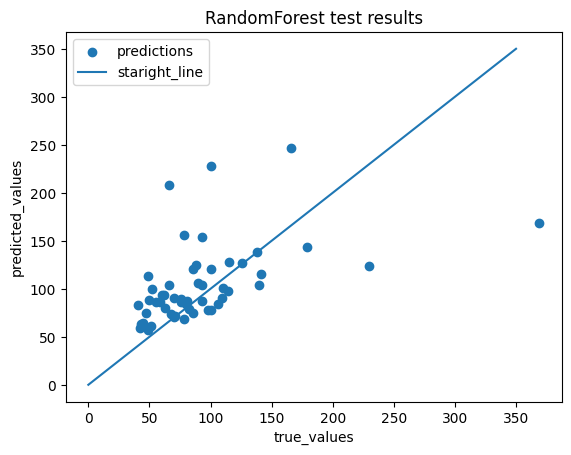

In [19]:
plt.scatter(y_test['price'], y_pred_rf, label='predictions')
plt.plot([0, 350], [0, 350], label='staright_line')
plt.xlabel('true_values')
plt.ylabel('predicted_values')
plt.title('RandomForest test results')
plt.legend()
plt.show()

#### ADA boosting

In [85]:
ada = AdaBoostClassifier()
ada.fit(x_train, y_train['price'])

AdaBoostClassifier()

In [86]:
# RMSE  for the holdout is 65.6
y_pred_ada = ada.predict(x_test)
mse_ada = mean_squared_error(y_test['price'], y_pred_ada)
np.sqrt(mse_ada)

65.56265353432195

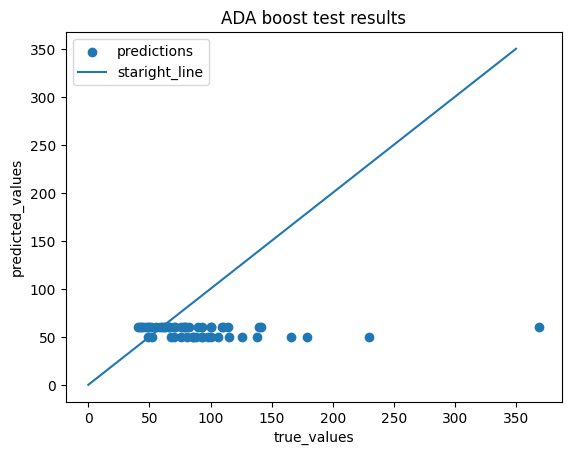

In [87]:
plt.scatter(y_test['price'], y_pred_ada, label='predictions')
plt.plot([0, 350], [0, 350], label='staright_line')
plt.xlabel('true_values')
plt.ylabel('predicted_values')
plt.title('ADA boost test results')
plt.legend()
plt.show()

### TASK2. Tesing best model on a new date

#### OLS as best model
In terms of RMSE OLS showed the best performance<br>
Meaning the linear relation to the target is more stronger than Tree based splitting<br>
Now check the model for predicting more recent prices, i.e. for the May instead of Jan 2023


In [88]:
# test data2 = May of 2023
test_data2 = athens_dated[(athens_dated['date_format']>='2023-05-01') & (athens_dated['date_format']<'2023-06-01')]
test_data2 = test_data2.dropna(subset='price').reset_index(drop=True)

In [89]:
# make x and y
x_test2 = test_data2.drop(['id', 'scrape_id', 'host_since', 'price', 'date_format'], axis=1)
y_test2 = test_data2[['id', 'price']].copy()

#### fillnans

In [90]:
# host_is_superhost is the only column with nans, fill it with the majority class
x_test2['host_is_superhost'] = x_test2['host_is_superhost'].fillna(0)

In [91]:
# no nans left
x_test2.isna().sum().sum()

0

In [92]:
# RMSE  for the holdout is 75.3
y2_pred_ols = results.predict(x_test2)
mse2_ols = mean_squared_error(y_test2['price'], y2_pred_ols)
np.sqrt(mse2_ols)

75.28250341500777

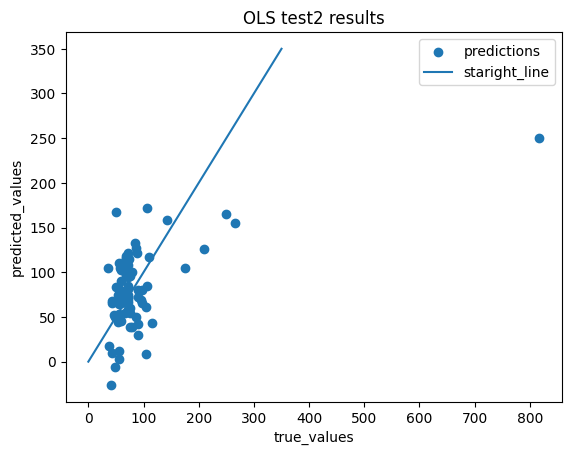

In [93]:
plt.scatter(y_test2['price'], y2_pred_ols, label='predictions')
plt.plot([0, 350], [0, 350], label='staright_line')
plt.xlabel('true_values')
plt.ylabel('predicted_values')
plt.title('OLS test2 results')
plt.legend()
plt.show()

as a result the model still capable for predicting the price<br>
the RMSE value has increased due to outlier with true price over 800<br>
without the outlier the RMSE returns back to normal, i.e. 41.4

In [98]:
# temporary calculations just to check the performance without outlier
temp_y_test = y_test2['price'].tolist()
temp_y_pred = y2_pred_ols.copy()
remove_ind = temp_y_test.index(817.0)
temp_y_test.pop(remove_ind)
temp_y_pred.pop(remove_ind)

249.65683121870993

In [100]:
# RMSE without outlier is 41.1
temp_mse = mean_squared_error(temp_y_test, temp_y_pred)
np.sqrt(temp_mse)

41.41038664877566

### TASK3. ASSESSING PERFORMANCE

In [20]:
explainer = shap.TreeExplainer(rf_search.best_estimator_)

In [21]:
shap_values = explainer.shap_values(x_test)

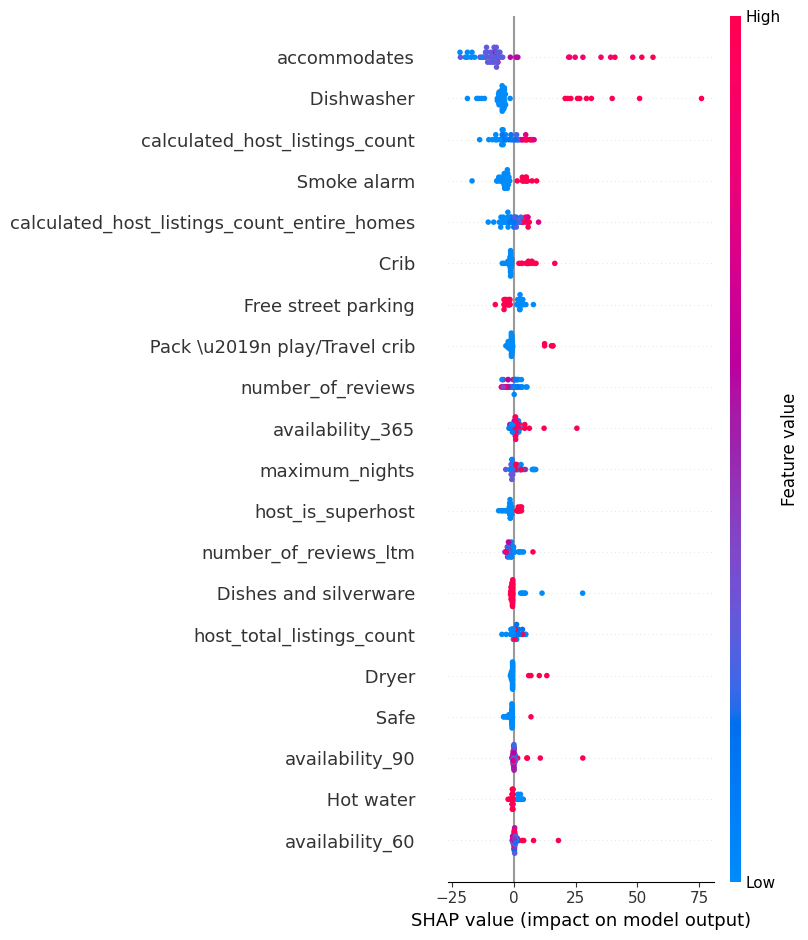

In [22]:
shap.summary_plot(shap_values, x_test)